In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type VERSION
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 29 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [4]:
data_bz = data["b2dz5"]  
data_bx = data["b2dx5"]  
data_by = data["b2dy5"]  

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 40.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 40.0 * 10**-3
pixelsize_y_Mm = 40.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 2000.0 * 10**-3

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 3.2 3.2 2.0
nresol_x, nresol_y, nresol_z 80 80 50
pixelsize_x 0.04
pixelsize_y 0.04
pixelsize_z 0.04


In [5]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [8]:
alpha = 0.12

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm 
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm 

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.4701191670896709


In [7]:
data2d = Field2dData(nresol_x, nresol_y, nresol_z, nf_max, pixelsize_x_Mm, pixelsize_y_Mm, pixelsize_z_Mm, x_arr, y_arr, z_arr, data_bz)

In [10]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA/ISSI_alpha0.12"

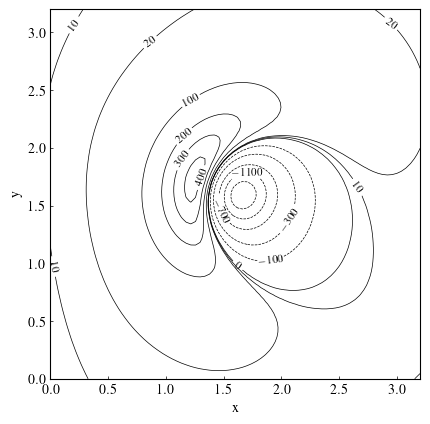

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  "/Users/lilli/Desktop/Thesis/ISSISA/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

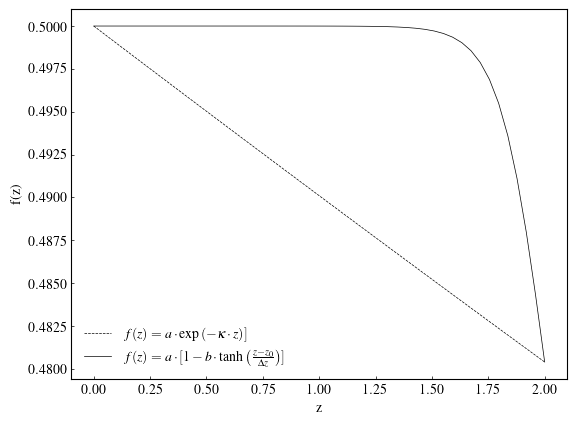

In [25]:
from mhsflex.switch import f, f_low

deltaz = z0 * 0.1

f_exp = np.zeros(nresol_z)
f_tanh = np.zeros(nresol_z)
a = 0.5 * np.exp(-0.02 * z0)
b = -(0.5 / a - 1.0) / np.tanh(-z0 / deltaz)

alpha = -0.12
# a = 0.4
# b = 1.0

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f_exp[iz] = f_low(z, 0.5, 0.02)
    f_tanh[iz] = f(z, z0, deltaz, a, b)

plt.plot(
    z_arr,
    f_exp,
    label=r"$f(z) = a \cdot \exp\left(- \kappa \cdot z \right)]$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f_tanh,
    label=r"$f(z) = a \cdot [1 - b \cdot \tanh\left(\frac{z - z_0}{\Delta z}\right)]$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/f.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [12]:
data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)

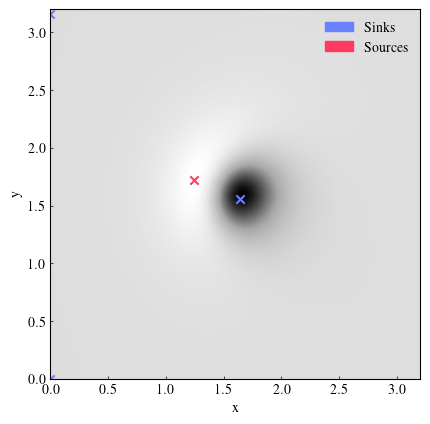

In [13]:
show_poles(data3d)

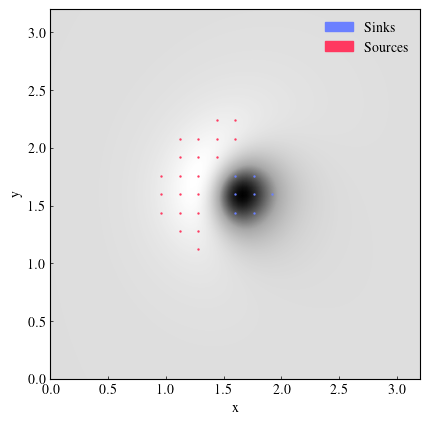

In [16]:
show_footpoints(data3d)

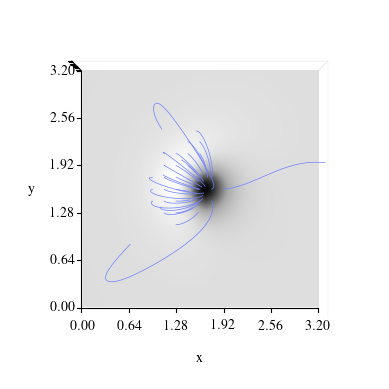

In [17]:
plot(data3d, 'los', False, True, path=folder)

In [36]:
plot(data3d, 'side', False, True, path=folder)

NameError: name 'data3d' is not defined

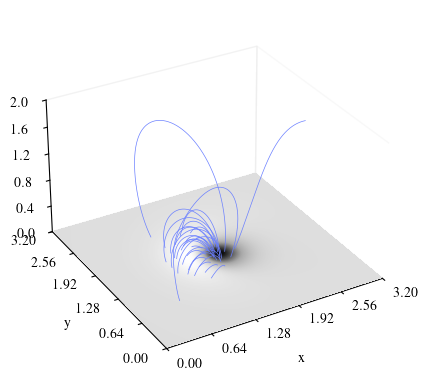

In [19]:
plot(data3d, 'angular', False, True, path=folder)

In [20]:
path3dref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3dref = readsav(path3dref, python_dict=True, verbose=True)

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

presref = data3dref["p3d"] * 10**-1
denref = data3dref["d3d"] * 10**3


bx_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
by_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bz_rec = data3d.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_rec = np.array((by_rec, bx_rec, bz_rec))
B_ref = np.array((issi_by, issi_bx, issi_bz))

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 8 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
(80, 80, 50)
(80, 80, 50)
(80, 80, 50)


In [ ]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

print(VecCorr(B_ref, B_rec))
print(CauSchw(B_ref, B_rec))
print(NormErr(B_ref, B_rec))
print(MeanErr(B_ref, B_rec))
print(MagEnergy(B_ref, B_rec))

print(VecCorr(B_ref, B_ref))
print(CauSchw(B_ref, B_ref))
print(NormErr(B_ref, B_ref))
print(MeanErr(B_ref, B_ref))
print(MagEnergy(B_ref, B_ref))

In [21]:
B_ref_See = np.zeros_like(data3d.field)

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]


In [22]:
Data3dref = Field3dData(nresol_x, nresol_y, nresol_z, nf_max, x_arr, y_arr, z_arr, data3d.bz, B_ref_See, np.zeros_like(B_ref_See), 0, 0, 0, 0, 0, tanh=True)

In [ ]:
from mhsflex.metrics import field_div_metric

field_div_metric(Data3dref, data3d)


In [33]:
temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

from mhsflex.field3d import bpressure_linear, bdensity_linear, btemp_linear, fpressure_linear, fdensity_linear

# backtemp = btemp_linear(data3d, heights, temps)
# backpres = bpressure_linear(data3d, heights, temps)
# backden = bdensity_linear(data3d, heights, temps)

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_63904/3335077373.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


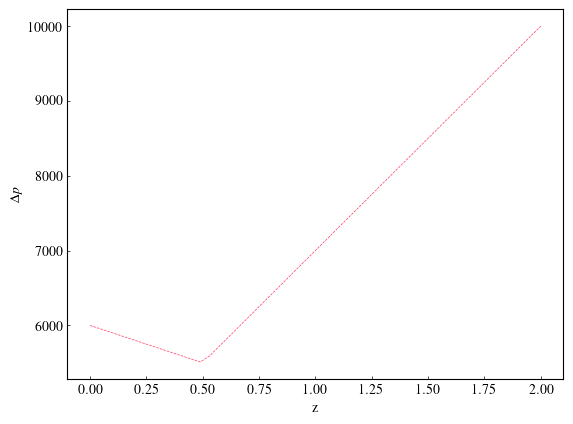

In [29]:
plt.plot(
    data3d.z,
    backtemp,
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
)
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_63904/706852611.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


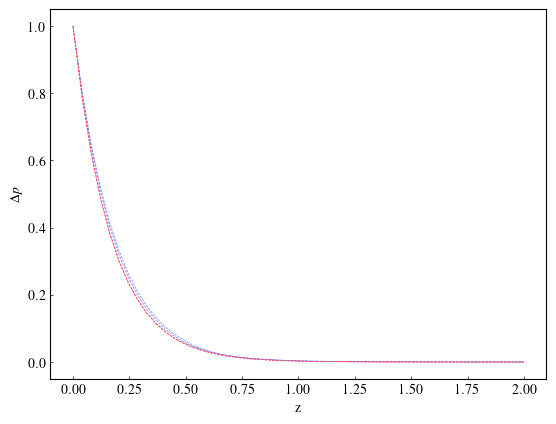

In [28]:
plt.plot(
    data3d.z,
    backden,
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
)
plt.plot(
    data3d.z,
    backpres,
    linewidth=0.5,
    linestyle="dashed",
    color=c2,
)
plt.plot(
    data3d.z,
    data3d.bpressure,
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
)
plt.plot(
    data3d.z,
    data3d.bdensity,
    linewidth=0.5,
    linestyle="dashed",
    color=c4,
)
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [30]:
maxcoord = np.unravel_index(
    np.argmax(data3d.bz, axis=None),
    data3d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

In [32]:
fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

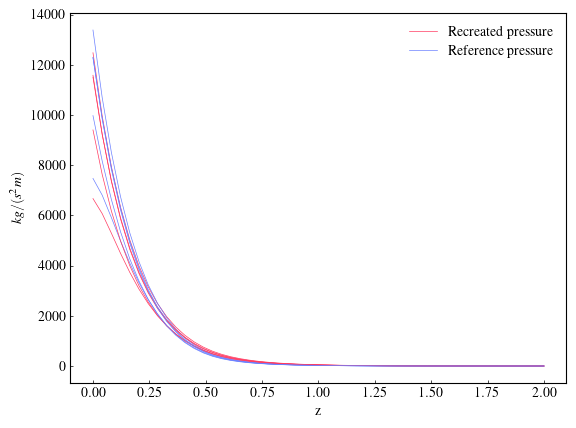

In [33]:
plt.plot(
    z_arr,
    fpres[0, 0, :],
    linewidth=0.5,
    color=c4,
    label="Recreated pressure",
)
plt.plot(
    z_arr,
    presref[:, 0, 0],
    linewidth=0.5,
    color=c2,
    #linestyle="dashed",
    label="Reference pressure",
)
for ix in range(40, 50, 5):
    for iy in range(40, 50, 5):
# for ix in range(nresol_x):
#     for iy in range(nresol_y):
        plt.plot(
            z_arr, fpres[iy, ix, :], linewidth=0.5, color=c4, #alpha=0.04
        )
        plt.plot(
            z_arr,
            presref[:, iy, ix],
            linewidth=0.5,
            color=c2,
            #linestyle="dashed",
            #alpha=0.04,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()



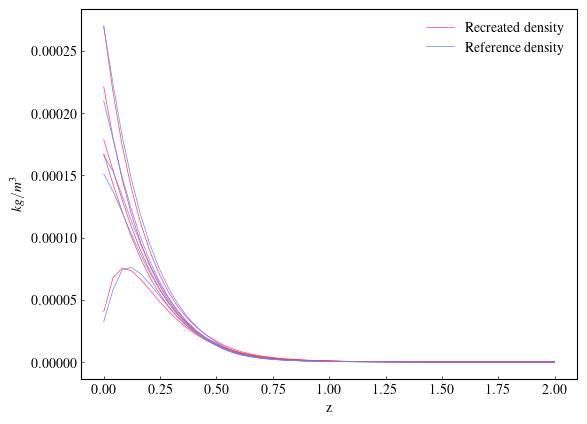

In [34]:
plt.plot(
    z_arr,
    fden[0, 0, :],
    linewidth=0.5,
    color=c4,
    label="Recreated density",
)
plt.plot(
    z_arr,
    denref[:, 0, 0],
    linewidth=0.5,
    color=c2,
    #linestyle="dashed",
    label="Reference density",
)
for ix in range(40, 50, 5):
    for iy in range(40, 50, 5):
        plt.plot(
            z_arr, fden[iy, ix, :], linewidth=0.5, color=c4, #alpha=0.04
        )
        plt.plot(
            z_arr,
            denref[:, iy, ix],
            linewidth=0.5,
            color=c2,
            #linestyle="dashed",
            #alpha=0.04,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
from mhsflex.metrics import pearson_corr_coeff_issi

pearson_corr_coeff_issi(presref, denref, data3d)

### POTENTIAL, LFF, MHS COMPARISON

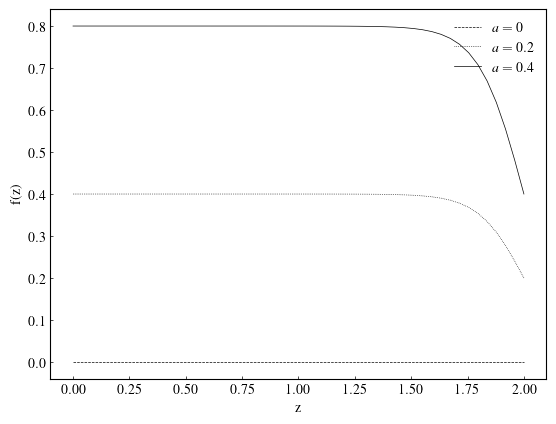

In [26]:
folder = "/Users/lilli/Desktop/Thesis/ISSISA"

deltaz = z0 * 0.1

f1 = np.zeros(nresol_z)
f2 = np.zeros(nresol_z)
f3 = np.zeros(nresol_z)

alpha = 0.2
a = 0.4
b = 1.0

for iz in range(0, nresol_z):
    z = z_arr[iz]
    f1[iz] = f(z, z0, deltaz, 0, b)
    f2[iz] = f(z, z0, deltaz, 0.2, b)
    f3[iz] = f(z, z0, deltaz, 0.4, b)

plt.plot(
    z_arr,
    f1,
    label=r"$a = 0$",
    linewidth=0.5,
    color="black",
    linestyle="dashed",
)
plt.plot(
    z_arr,
    f2,
    label=r"$a =0.2$",
    linewidth=0.5,
    color="black",
    linestyle="dotted",
)
plt.plot(
    z_arr,
    f3,
    label=r"$a =0.4$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("f(z)")
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/f.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [27]:
data3dp = calculate_magfield(data2d, 0, b, 0, z0, deltaz)
data3dlff = calculate_magfield(data2d, 0, b, 0.2, z0, deltaz)
data3dm1 = calculate_magfield(data2d, 0.2, b, 0.2, z0, deltaz)
data3dm2 = calculate_magfield(data2d, 0.4, b, 0.2, z0, deltaz)

In [ ]:
compare_field3d(data3dlff, data3dm1)

In [ ]:
compare_field3d(data3dm1, data3dm2)

In [ ]:
compare_field3d(data3dlff, data3dm2)

In [34]:
fpreslff = fpressure_linear(data3dlff, heights, temps)
fdenlff = fdensity_linear(data3dlff, heights, temps)

fpresm1 = fpressure_linear(data3dm1, heights, temps)
fdenm1 = fdensity_linear(data3dm1, heights, temps)

fpresm2 = fpressure_linear(data3dm2, heights, temps)
fdenm2 = fdensity_linear(data3dm2, heights, temps)

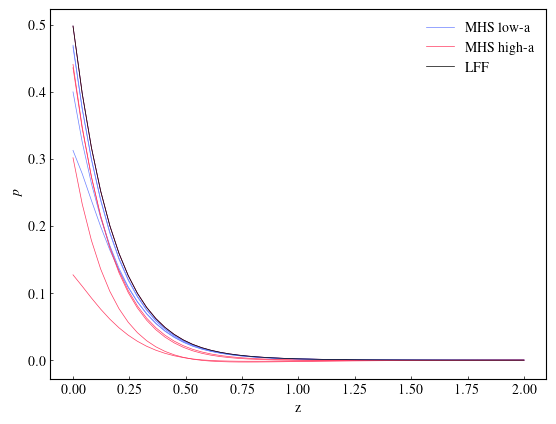

In [37]:

plt.plot(
    z_arr,
    fpresm1[0, 0, :],
    linewidth=0.5,
    color=c2,
    #linestyle="dashed",
    label="MHS low-a",
)
plt.plot(
    z_arr,
    fpresm2[0, 0, :],
    linewidth=0.5,
    color=c4,
    #linestyle="dashed",
    label="MHS high-a",
)
for ix in range(40, 50, 5):
    for iy in range(40, 50, 5):
# for ix in range(nresol_x):
#     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpresm1[iy, ix, :],
            linewidth=0.5,
            color=c2,
            #linestyle="dashed",
            #alpha=0.04,
        )
        plt.plot(
            z_arr,
            fpresm2[iy, ix, :],
            linewidth=0.5,
            color=c4,
            #linestyle="dashed",
            #alpha=0.04,
        )
plt.plot(
    z_arr,
    fpreslff[0, 0, :],
    linewidth=0.5,
    color="black",
    label="LFF",
)
plt.ylabel("$p$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

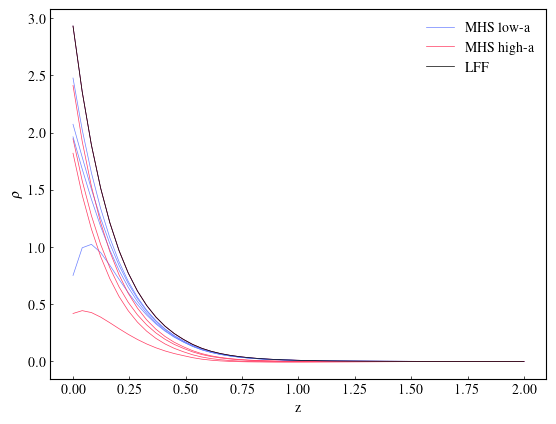

In [39]:
plt.plot(
    z_arr,
    fdenm1[0, 0, :],
    linewidth=0.5,
    color=c2,
    label="MHS low-a",
)
plt.plot(
    z_arr,
    fdenm2[0, 0, :],
    linewidth=0.5,
    color=c4,
    #linestyle="dashed",
    label="MHS high-a",
)
for ix in range(40, 50, 5):
    for iy in range(40, 50, 5):
        plt.plot(
            z_arr, fdenm1[iy, ix, :], linewidth=0.5, color=c2, #alpha=0.04
        )
        plt.plot(
            z_arr,
            fdenm2[iy, ix, :],
            linewidth=0.5,
            color=c4,
            #linestyle="dashed",
            #alpha=0.04,
        )
plt.plot(
    z_arr,
    fdenlff[0, 0, :],
    linewidth=0.5,
    color="black",
    label="LFF",
)
plt.ylabel(r"$\rho$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()